## Импорты

In [1]:
import pandas as pd
import numpy as np
import os
import warnings

warnings.filterwarnings("ignore")
import seaborn as sns

## Загрузка данных

In [2]:
data = pd.read_csv("../data/raw/train.csv", index_col="row_id")
data["timestamp"] = data["timestamp"].astype("datetime64[ns]")
data_test = pd.read_csv("../data/raw/test.csv", index_col="row_id")
data_test["timestamp"] = data_test["timestamp"].astype("datetime64[ns]")

In [4]:
data_features = pd.concat([data.drop(columns=["user_id"]), data_test])
data_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44643 entries, 0 to 44642
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  44643 non-null  datetime64[ns]
 1   gate_id    44643 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.0 MB


In [5]:
len(data_features["timestamp"].dt.date.unique())

184

<Axes: xlabel='timestamp', ylabel='Count'>

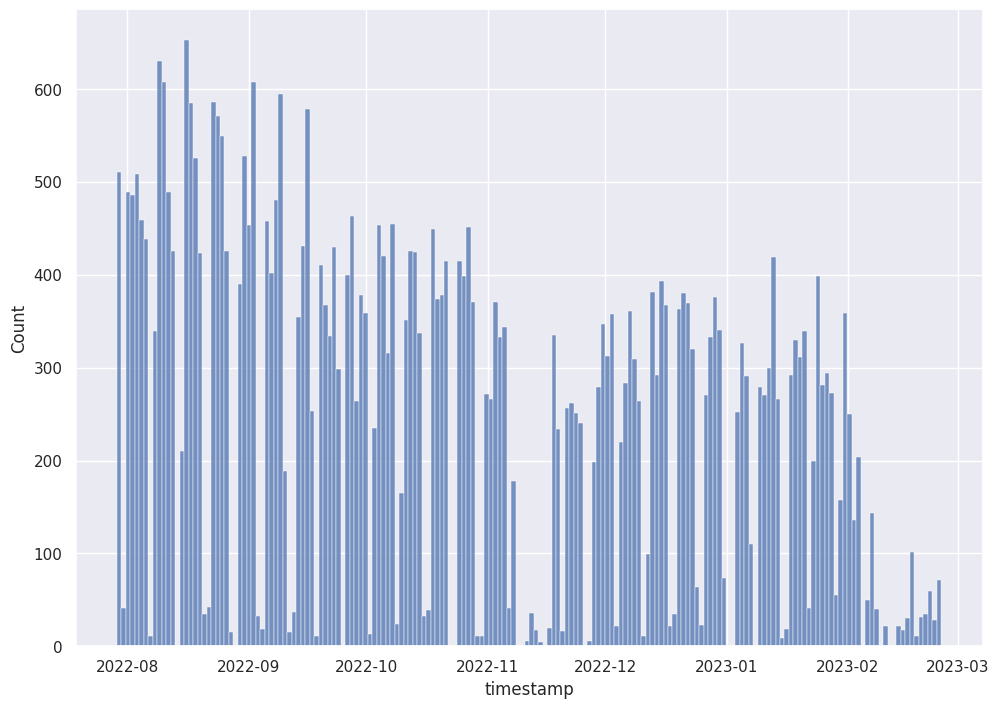

In [6]:
sns.set(rc={"figure.figsize": (11.7, 8.27)})
sns.histplot(data=data_features, x="timestamp", bins=184, palette="husl")

<Axes: xlabel='timestamp', ylabel='Count'>

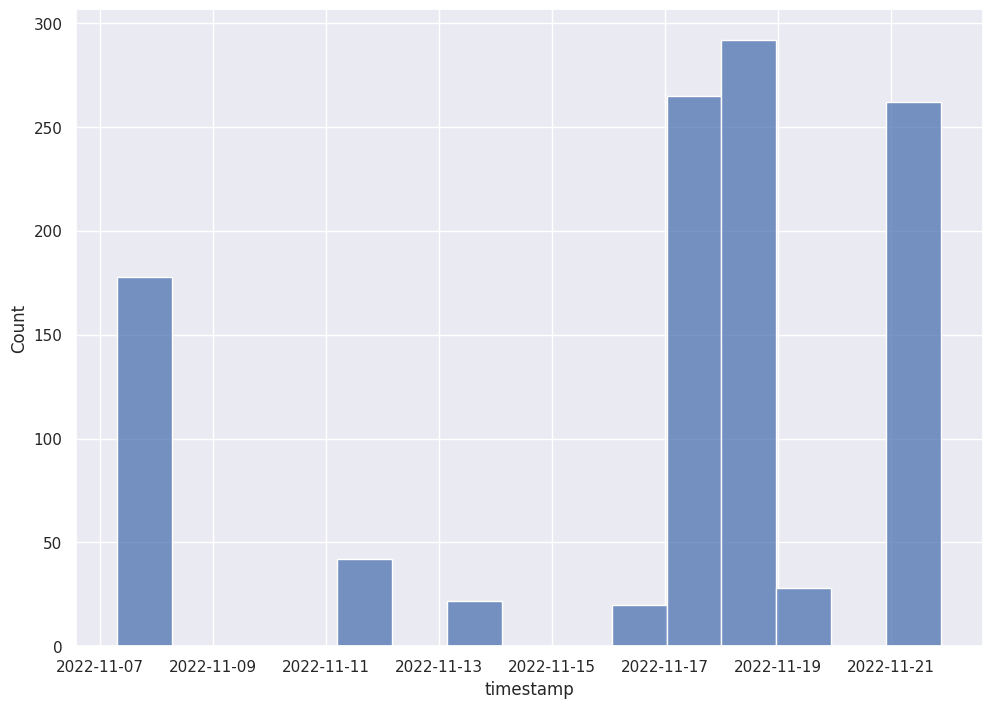

In [15]:
sns.histplot(
    data=data_features[
        (data_features["timestamp"] >= "2022-11-07 00:00:00")
        & (data_features["timestamp"] <= "2022-11-22 00:00:00")
    ],
    x="timestamp",
    bins=15,
    palette="husl",
)

In [16]:
data_clear_do = data_features[
    data_features["timestamp"] < "2022-11-07 00:00:00"
]

In [20]:
data_clear_posle = data_features[
    data_features["timestamp"] >= "2022-11-21 00:00:00"
]

In [23]:
data_clear_do.tail(10)

,timestamp,gate_id
row_id,,
28179,2022-11-06 18:06:20,3
28180,2022-11-06 18:06:21,3
28181,2022-11-06 18:06:39,10
28182,2022-11-06 19:26:41,13
28183,2022-11-06 19:26:42,13
28184,2022-11-06 21:00:13,11
28185,2022-11-06 21:00:32,6
28186,2022-11-06 21:00:32,6
28187,2022-11-06 21:00:40,9


In [24]:
data_clear_do["timestamp"] = data_clear_do["timestamp"] + pd.Timedelta(days=14)

In [26]:
data_clear_do.head(10)

,timestamp,gate_id
row_id,,
0,2022-08-12 09:08:54,7
1,2022-08-12 09:09:54,9
2,2022-08-12 09:09:54,9
3,2022-08-12 09:10:06,5
4,2022-08-12 09:10:08,5
5,2022-08-12 09:10:34,10
6,2022-08-12 09:32:47,11
7,2022-08-12 09:33:12,4
8,2022-08-12 09:33:13,4


In [75]:
sorted(data["gate_id"].unique())

[-1, 0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [76]:
sorted(data_test["gate_id"].unique())

[-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [77]:
data_test["gate_id"][data_test["gate_id"] == 2]

row_id
39911    2
39912    2
39928    2
39929    2
Name: gate_id, dtype: int64

### В тестовых данных нет gate_id = 0 и 16, есть gate_id = 2, которого нет в обучающей выборке

In [78]:
data["hour"] = data["timestamp"].dt.hour
data["minute"] = data["timestamp"].dt.minute
data["day"] = data["timestamp"].dt.day
data["dayofweek"] = data["timestamp"].dt.dayofweek
data["is_weekend"] = data["dayofweek"] > 4
data["is_weekend"] = data["is_weekend"].apply(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37518 entries, 0 to 37517
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     37518 non-null  int64         
 1   timestamp   37518 non-null  datetime64[ns]
 2   gate_id     37518 non-null  int64         
 3   hour        37518 non-null  int32         
 4   minute      37518 non-null  int32         
 5   day         37518 non-null  int32         
 6   dayofweek   37518 non-null  int32         
 7   is_weekend  37518 non-null  int64         
dtypes: datetime64[ns](1), int32(4), int64(3)
memory usage: 2.0 MB


In [81]:
data[data["hour"] == 6]

,user_id,timestamp,gate_id,hour,minute,day,dayofweek,is_weekend
row_id,,,,,,,,
35802,1,2022-12-23 06:29:02,15,6,29,23,4,0
35803,1,2022-12-23 06:32:01,9,6,32,23,4,0
35804,1,2022-12-23 06:32:01,9,6,32,23,4,0
35805,1,2022-12-23 06:32:15,5,6,32,23,4,0
35806,1,2022-12-23 06:32:16,5,6,32,23,4,0
35807,1,2022-12-23 06:32:42,10,6,32,23,4,0


## Посмотрим на пользователей

In [40]:
# посмотрим пользователей которые проходят через ПК (пунтк контроля) реже всего
data["user_id"].value_counts(ascending=True).head(10)

user_id
4      2
51     3
44     4
21     5
52     5
30    10
5     10
38    13
10    17
8     29
Name: count, dtype: int64

Если удалить этих пользователей станет ли прогноз лучше?

In [53]:
data["gate_id"].value_counts(ascending=False).head(20)

gate_id
 4     8170
 3     5351
 10    4767
 5     4619
 11    4090
 9     3390
 7     3026
 6     1800
 13    1201
 12     698
 15     298
-1       48
 8       48
 1        5
 16       4
 0        2
 14       1
Name: count, dtype: int64

<Axes: xlabel='hour', ylabel='Count'>

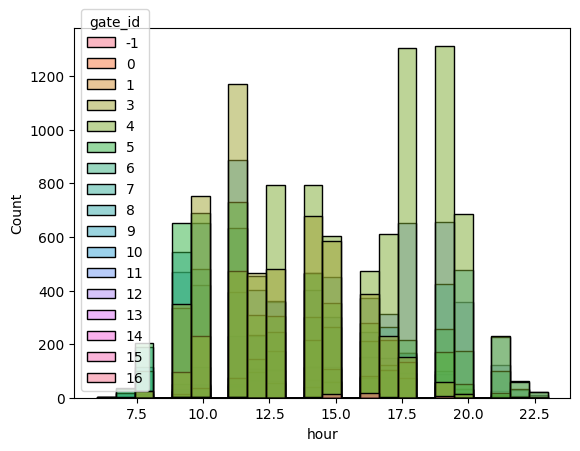

In [4]:
# Посмотрим на распределение по часам и gate_id
sns.histplot(data=data, x="hour", bins=24, hue="gate_id", palette="husl")

<Axes: xlabel='hour', ylabel='Count'>

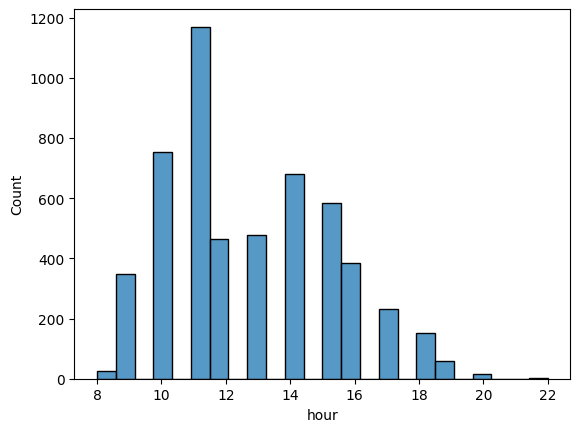

In [31]:
sns.histplot(data=data[(data["gate_id"] == 3)], x="hour", bins=24)

<Axes: xlabel='dayofweek', ylabel='Count'>

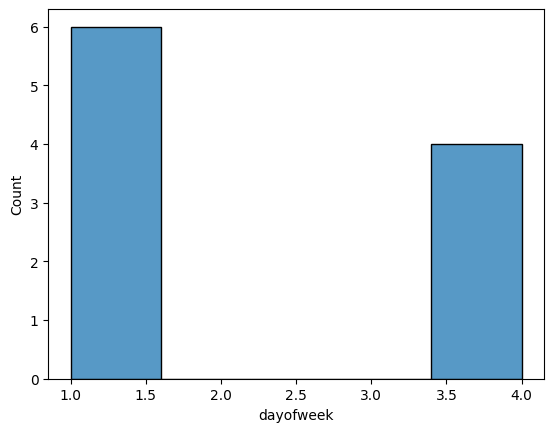

In [58]:
sns.histplot(data=data[data["user_id"] == 30], x="dayofweek")